# Orthogroup analysis of matrisoms
This pipeline takes multiple collections of proteins from different species and performs an orthogroup analysis with the goal of grouping orthologues together.
It expects a folder with fasta files named in this pattern "Taxonomic_group_Genus_species.fasta"

CITATION:

 When publishing work that uses OrthoFinder please cite:
 > Emms D.M. & Kelly S. (2019), Genome Biology 20:238

 If you use the species tree in your work then please also cite:
 >Emms D.M. & Kelly S. (2017), MBE 34(12): 3267-3278
 >
 >Emms D.M. & Kelly S. (2018), bioRxiv https://doi.org/10.1101/267914

## Install orthofinder


We need to import a number of packages

In [22]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from Bio import Phylo,SeqIO,BiopythonParserWarning
from matplotlib_venn import venn2,venn3 # A library for creating venn diagrams
from tqdm import tqdm # A library for creating progress bars
import holoviews as hv # A library for creating interactive visualizations
from bokeh.io import export_svgs
from venn import venn
from adjustText import adjust_text
import numpy as np
import warnings

In [23]:
#define where the input files are
input_folder = Path(r"output/orthofinder_input/matrisome")

#where did you install orthofinder?
orthofinder_directory = Path(r"./orthofinder/OrthoFinder/orthofinder")

#where do you want to save the resulting statistics, graphs and images
output_path = input_folder / "Orthogroup_analysis"
graph_path = output_path / "graphs"
graph_path.mkdir(parents = True, exist_ok = True)
image_path = output_path / "image"
image_path.mkdir(parents = True, exist_ok = True)

color_map = ["#AFDB00","#72BCE4","#FF00FF","#FF7F0E"]
colors = {  'Choanozoa':"#ff2a7f",
            'Chordata':"#beaed4",
            'Anthozoa':"#ed7d31",
            'Cubozoa': "#bdd7ee",
            'Hydrozoa':"#00b0f0",
            'Scyphozoa':"#4472c4",
            'Staurozoa':"#1f4e79", 
            'Ctenophora':"#ffc000", 
            'Myxozoa':"#8faadc", 
            'Nematoda':"#00c35e",
            'Placozoa':"#666666", 
            'Porifera':"#800000", 
            'Platyhelminthes':"#FF7F0E",
            'Insecta':"#AFDB00"}

candidates = pd.read_excel("Candidate Liste.xlsx",index_col=0)

In [24]:
# Functions
def replace_uppercase_with_lowercase(match):
    """
    Helper function to convert the first character of a matched pattern to lowercase.

    Parameters:
        match (re.Match): A regular expression match object.

    Returns:
        str: Modified string with first character in lowercase.
    """
    return match.group(0).lower()[0]

def assign_color(row,col_name):
    """
    Assign color category based on the 'Category' column values.

    Parameters:
        row (pd.Series): A row from the dataframe.

    Returns:
        str: Assigned color category.
    """
    if row[col_name][0] == 'Cnidaria':
        return row[col_name][1]
    return row[col_name][0]

def is_overlapping(x, y, text, existing_positions, threshold=10):
    """
    Check if a text label overlaps with existing positions.

    Parameters:
        x (float): x-coordinate of the text label.
        y (float): y-coordinate of the text label.
        text (str): Text label.
        existing_positions (list): List of existing positions.
        threshold (int, optional): Threshold for overlap detection. Default is 10.

    Returns:
        bool: True if there is overlap, False otherwise.
    """
    for pos in existing_positions:
        if abs(x - pos[0]) < threshold and abs(y - pos[1]) < threshold:
            return True
    return False
from matplotlib.patches import Patch
def scatter_plot_with_labels(dataframe,seq_row,OG_row, include_labels=None,):
    """
    Generate a scatter plot with optional labels for specific rows.

    Parameters:
        dataframe (pd.DataFrame): Input dataframe containing 'Matrisome size', '# Orthogroups', and 'Color Category' columns.
        include_labels (list, optional): List of labels to include. If None, all labels will be included. Default is None.

    Returns:
        None
    """
    cleaned_dataframe = dataframe.dropna()

    # Create the scatter plot
    plt.scatter(cleaned_dataframe[seq_row], cleaned_dataframe[OG_row], c=cleaned_dataframe['Color Category'].map(colors))
    plt.xlabel("Matrisome size")
    plt.ylabel("# Orthogroups")

    texts = []     
    for i, row in cleaned_dataframe.iterrows():
        # Check if label should be included
        if not include_labels or row['name'] in include_labels:
            texts.append(plt.text(row[seq_row] + 30, row[OG_row], row['name'], fontsize=6,color=colors.get(row['Color Category'],"black")))

    if len(texts) > 1:
        # Adjust text positions to avoid overlap
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

    # Add legend
    categories = cleaned_dataframe['Color Category'].unique()
    legend_labels = [Patch(color=colors[category], label=category) for category in categories]
    plt.legend(handles=legend_labels, loc='lower right',prop={'size': 5.5},frameon=False,ncols=2)

OrthoFinder will be run manually because it takes a lot of time to finish and I want to ive the user the control over when it is being run. But I will build the command line arguments.

In [25]:
#-f /mnt/d/Data/programs/mesoglea_protein_pipeline/output/orthofinder_input/matrisome -t 14 -a 14;
command = f'\u001b[33m{orthofinder_directory}\033[0m '
command += f'\033[1;32;1m-f\033[0m /mnt/{input_folder} '#input path (the /mnt/  allows me to access winsowds files from the WSL)
command += f'\033[1;32;1m-t\033[0m 14 ' #number of threads
command += f'\033[1;32;1m-a\033[0m 14 ' #number of threads for BLAST alignment
command = command.replace("\\","/")
command = re.sub(r"[A-Z]:",replace_uppercase_with_lowercase,command)
print("Run this command:")
print("ulimit -n 4000")
print(command)

Run this command:
ulimit -n 4000
orthofinder/OrthoFinder/orthofinder -f /mnt/output/orthofinder_input/matrisome -t 14 -a 14 


This will create a new folder in the input directory which contains the Result files. each run creates a new subfolder so we need to select the latest run.

In [26]:
# Get a list of all the directories in the OrthoFinder directory
orthofinder_dirs = [p for p in Path(f"{input_folder}/OrthoFinder").iterdir() if p.is_dir()]
#Sort the directories by name
orthofinder_dirs.sort()
# Find the most recent run by taking the last element in the sorted list
most_recent_run = orthofinder_dirs[-1]
# Use the most recent run to create the orthofinder_dir
orthofinder_dir = f"{most_recent_run}/"
OF_path = orthofinder_dir
print("Selected OrthoFinder Analysis:")
print(f'\033[1;32;1m{OF_path}\033[0m')

Selected OrthoFinder Analysis:
output\orthofinder_input\matrisome\OrthoFinder\Results_Jul16/


The first qualti control check we want to do is to check the resulting species tree. Orthofinder creates a species Tree based on the defined orthogroups (you can also provide it with a tree as input to refine your analysis). This tree can give us some idea about large scale problems with our dataset. 

In [28]:
# Read the tree file
tree = Phylo.read(OF_path + "Species_Tree/SpeciesTree_rooted.txt", "newick")
# Draw the full matrisome tree
plt.title = "Species Tree"

#Phylo.draw(tree)

#plt.savefig(image_path / f"species_tree.svg")

How many orthogroups were found?

In [29]:
# count total orthogroups
OGs = pd.read_csv(
    OF_path + "Orthogroups/Orthogroups.tsv",
    sep="\t",
    index_col=0,
)
HOGs = pd.read_csv(
    OF_path + "/Phylogenetic_Hierarchical_Orthogroups/N0.tsv",
    sep="\t",
    index_col=0,
)
print(f"Identified {OGs.shape[0]} Orthogroups(OG).")
print(f"Identified {HOGs.shape[0]} Phylogenetically Hirarchical Orthogroups (HOGS).")

Identified 2432 Orthogroups(OG).
Identified 2484 Phylogenetically Hirarchical Orthogroups (HOGS).


How many Orthogroups do the different species have?

In [30]:
#a number of columns need to be dropped
exclude_list = ["OG","Gene Tree Parent Clade","Annelida_Pleistoannelida_Capitella_teleta"]
HOGs_clean = HOGs.sort_index().drop(exclude_list,axis=1)
HOG_count = HOGs_clean.count()
HOG_count.to_csv(output_path  / "HOGs_per_species.csv")
#HOG_count = HOG_count.drop(['Chordata_Amphioxiformes_Branchiostoma_lanceolatum',
#       'Chordata_Amphioxiformes_Branchiostoma_floridae',
#       'Chordata_Amphioxiformes_Branchiostoma_belcheri'       ])
custom_order = ["Choanozoa",
                "Porifera",
                "Ctenophora",
                "Placozoa",
                "Cnidaria",
                #"Platyhelminthes",
                "Nematoda",
                "Insecta",
                "Chordata"]
HOG_count.index = pd.MultiIndex.from_tuples(HOG_count.index.str.split('_', expand=True),names = ["phylum","class","genus","species"])
HOG_count = pd.DataFrame(HOG_count, columns=["# Orthogroups"])
HOG_count = HOG_count.loc[custom_order]
HOG_count

# Orthogroups
phylum     class             genus          species                         
Choanozoa  Choanoflagellatea Monosiga       brevicollis                   90
                             Salpingoeca    rosetta                      112
Porifera   Demospongiae      Amphimedon     queenslandica                202
                             Ephydatia      muelleri                     193
Ctenophora Nuda              Beroe          ovata                        184
           Tentaculata       Mnemiopsis     leidyi                       203
                             Pleurobrachia  bachei                       248
Placozoa   Trichoplacidae    Trichoplax     spec-H2                      197
                                            specH2                       197
                             Tricoplax      adhaerens                    158
Cnidaria   Anthozoa          Acropora       cervicornis                  289
                                            digitifera                   289
                                            hyacinthus                   146
                                            millepora                    281
                                            muricata                     171
                             Actinia        tenebrosa                    366
                             Exaiptasia     diaphana                     341
                             Montipora      aequituberculata             184
                                            foliosa                      108
                             Nematostella   vectensis                    326
                             Pocillopora    damicornis                   235
                                            verrucosa                    200
                             Porites        asteroides                   187
                             Renilla        reniformis                   110
                             Stylophora     pistillata                   377
                             Xenia          spec                         192
           Cubozoa           Morbakka       virulenta                    249
           Hydrozoa          Clytia         hemispherica                 268
                             Hydra          viridissima                  271
                                            vulgaris                     274
                             Hydractinia    echinata                     371
                                            symbiolongicarpus            341
           Myxozoa           Myxobolus      honghuensis                   72
                             Thelohanellus  kitauei                       40
           Scyphozoa         Aurelia        aurita                       248
                             Cassiopea      xamachana                    235
           Staurozoa         Calvadosia     cruxmelitensis               316
Nematoda   Chromadorea       Caenorhabditis elegans                       87
Insecta    Diptera           Drosophila     melanogaster                  82
Chordata   Amphioxiformes    Branchiostoma  belcheri                     788
                                            floridae                     800
                                            lanceolatum                  771
           Vertebrata        Bos            taurus                       285
                             Coturnix       japonica                     196
                             Danio          rerio                        171
                             Homo           sapiens                      206
                             Mus            musculus                     203

In [31]:
HOGs_clean = HOGs_clean.T
HOGs_clean.index = pd.MultiIndex.from_tuples(HOGs_clean.index.str.split('_', expand=True),names = ["phylum","class","genus","species"])
HOG_clean = HOGs_clean.loc[custom_order]

In [32]:
HOGs_clean = HOGs_clean.fillna("")
HOGs_clean

HOG                                                                                                     N0.HOG0000000  \
phylum          class             genus          species                                                                
Choanozoa       Choanoflagellatea Monosiga       brevicollis        Monosiga_brevicollisXP_001748741.1 XP_00174874...   
                                  Salpingoeca    rosetta            Salpingoeca_rosetta_XP_004991603.1 XP_00499160...   
Chordata        Amphioxiformes    Branchiostoma  belcheri           Branchiostoma_belcheri_tr_A0A6P5A4R6_A0A6P5A4R...   
                                                 floridae           Branchiostoma_floridae_tr_A0A9J7NBS4_A0A9J7NBS...   
                                                 lanceolatum        Branchiostoma_lanceolatum_tr_A0A8J9YR23_A0A8J9...   
                Vertebrata        Bos            taurus             NP_001137570.1 meprin A subunit beta precursor...   
                                  Coturnix       japonica           Coturnix_japonica_XP_015710982.1 meprin A subu...   
                                  Danio          rerio              Danio_rerio_tr_B8JKC0_B8JKC0_DANRE tr|B8JKC0|B...   
                                  Homo           sapiens            Homo_sapiens_sp_Q16819_MEP1A_HUMAN sp|Q16819|M...   
                                  Mus            musculus           Mus_musculus_sp_P28825_MEP1A_MOUSE sp_P28825_M...   
Cnidaria        Anthozoa          Acropora       cervicornis        Acropora_cervicornis_comp59880_c0_seq1 comp598...   
                                                 digitifera         Acropora_digitifera_adi_v1.01716 adi_v1.01716,...   
                                                 hyacinthus         Acropora_hyacinthus_GCKDGN103F7BX2 GCKDGN103F7...   
                                                 millepora          Acropora_millepora_c017051 c017051 extracted_C...   
                                                 muricata           Acropora_muricata_transcript_HQ_E2_1_transcrip...   
                                  Actinia        tenebrosa          Actinia_tenebrosa_tr_A0A6P8IVQ7_A0A6P8IVQ7_ACT...   
                                  Exaiptasia     diaphana           Exaiptasia_diaphana_XP_020898002.1 XP_02089800...   
                                  Montipora      aequituberculata   Montipora_aequituberculata_comp116774_c0_seq1 ...   
                                                 foliosa            Montipora_foliosa_transcript_HQ_E3_1_transcrip...   
                                  Nematostella   vectensis          Nematostella_vectensis_NV2t015362001.1 NV2t015...   
                                  Pocillopora    damicornis         Pocillopora_damicornis_transcript_HQ_P2_transc...   
                                                 verrucosa          Pocillopora_verrucosa_transcript_HQ_E1_1_trans...   
                                  Porites        asteroides         Porites_asteroides_isotig08230 isotig08230 ext...   
                                  Renilla        reniformis         Renilla_reniformis_g9078.t1 g9078.t1, Renilla_...   
                                  Stylophora     pistillata         Stylophora_pistillata_Spis16898 Spis16898 Spis...   
                                  Xenia          spec               Xenia_spec_Xe_013630_T1 Xe_013630_T1 Xe_013630...   
                Cubozoa           Morbakka       virulenta          Morbakka_virulenta_scaffold4121.g1.t1 scaffold...   
                Hydrozoa          Clytia         hemispherica       Clytia_hemispherica_TCONS_00071642-protein TCO...   
                                  Hydra          viridissima        Hydra_viridissima_scaffold22.g135.t1 scaffold2...   
                                                 vulgaris           Hydra_vulgaris_Sc4wPfr_264.g27426.t2 Sc4wPfr_2...   
                                  Hydractinia    echinata           Hydractinia_echinata_HyE0056.36 HyE0056.36, Hy...   
       

In [33]:
def count_commas_in_cell(cell_value):
    if str(cell_value).strip():  # Check if cell is not empty after stripping whitespace
        return len(str(cell_value).split(','))
    else:
        return 0  # Return 0 for empty cells
HOG_clean_seq_count = HOGs_clean.applymap(count_commas_in_cell)
HOG_clean_seq_count

HOG                                                                 N0.HOG0000000  \
phylum          class             genus          species                            
Choanozoa       Choanoflagellatea Monosiga       brevicollis                    1   
                                  Salpingoeca    rosetta                        1   
Chordata        Amphioxiformes    Branchiostoma  belcheri                      93   
                                                 floridae                     101   
                                                 lanceolatum                   97   
                Vertebrata        Bos            taurus                        11   
                                  Coturnix       japonica                       8   
                                  Danio          rerio                         18   
                                  Homo           sapiens                        6   
                                  Mus            musculus                       8   
Cnidaria        Anthozoa          Acropora       cervicornis                   72   
                                                 digitifera                    72   
                                                 hyacinthus                    47   
                                                 millepora                     97   
                                                 muricata                      30   
                                  Actinia        tenebrosa                    117   
                                  Exaiptasia     diaphana                     156   
                                  Montipora      aequituberculata              48   
                                                 foliosa                       18   
                                  Nematostella   vectensis                    121   
                                  Pocillopora    damicornis                    64   
                                                 verrucosa                     48   
                                  Porites        asteroides                    51   
                                  Renilla        reniformis                     4   
                                  Stylophora     pistillata                    90   
                                  Xenia          spec                          28   
                Cubozoa           Morbakka       virulenta                    110   
                Hydrozoa          Clytia         hemispherica                  79   
                                  Hydra          viridissima                   56   
                                                 vulgaris                      71   
                                  Hydractinia    echinata                     140   
                                                 symbiolongicarpus            111   
                Myxozoa           Myxobolus      honghuensis                    0   
                                  Thelohanellus  kitauei                        1   
                Scyphozoa         Aurelia        aurita                        92   
                                  Cassiopea      xamachana                     75   
                Staurozoa         Calvadosia     cruxmelitensis               116   
Ctenophora      Nuda              Beroe          ovata                         12   
                Tentaculata       Mnemiopsis     leidyi                        12   
                                  Pleurobrachia  bachei                        17   
Insecta         Diptera           Drosophila     melanogaster                  10   
Nematoda        Chromadorea       Caenorhabditis elegans                       57   
Placozoa        Trichoplacidae    Trichoplax     spec-H2                       17   
                                                 specH2                        17   
                                  Tricoplax      adhaerens                     21   
Platy

In [34]:
published_matrisomes = [("Chordata","Vertebrata","Homo","sapiens"),
                        ("Chordata","Vertebrata","Mus","musculus"),
                        ("Chordata","Vertebrata","Bos","taurus"),
                        ("Chordata","Vertebrata","Danio","rerio"),
                        ("Chordata","Vertebrata","Coturnix","japonica"),
                        ("Nematoda","Chromadorea","Caenorhabditis","elegans"),
                        #("Platyhelminthes","Tricladida","Schmidtea","mediterranea"),
                        ("Insecta","Diptera","Drosophila","melanogaster")]

In [35]:
published_reduction = HOGs_clean.loc[:,HOG_clean_seq_count.loc[published_matrisomes].sum() > 0]
published_reduction_seq_count = HOG_clean_seq_count.loc[:,HOG_clean_seq_count.loc[published_matrisomes].sum() > 0]
published_reduction_mat_size = published_reduction_seq_count.sum(axis=1)
published_reduction_mat_size.name="adjusted_matrisome_size"
published_reduction_mat_size

phylum           class              genus           species          
Choanozoa        Choanoflagellatea  Monosiga        brevicollis           105
                                    Salpingoeca     rosetta               178
Chordata         Amphioxiformes     Branchiostoma   belcheri             1828
                                                    floridae             2104
                                                    lanceolatum          1924
                 Vertebrata         Bos             taurus                946
                                    Coturnix        japonica              590
                                    Danio           rerio                 737
                                    Homo            sapiens               588
                                    Mus             musculus              677
Cnidaria         Anthozoa           Acropora        cervicornis           842
                                                    digitifera          

In [36]:
ax = published_reduction_mat_size.plot(kind="bar")
# Define a list to hold custom positions
positions = []

labels = [f"{i[0]}|{i[2]} {i[3]}" for i in published_reduction_mat_size.index]

for idx, label in enumerate(HOG_count.index):
    first_level_value = label[0]
    if first_level_value == "Cnidaria":
        first_level_value = label[1]
    color = colors.get(first_level_value, 'black')  # Default to black if color is not found
    ax.get_xticklabels()[idx].set_color(color)
    position = idx * 1.5  # Adjust 1.5 as needed to control spacing
    positions.append(position)
ax.set_xticklabels(labels)
plt.title="adjusted_matrisome_size"
plt.savefig(graph_path / f"publication-adjusted-mat-size.svg")

ImportError: cannot import name '_check_savefig_extra_args' from 'matplotlib.backend_bases' (c:\programs\anaconda\envs\cellpose\lib\site-packages\matplotlib\backend_bases.py)

In [37]:
def count_positive_values(row):
    return (row > 0).sum()
published_reduction_OG_count = published_reduction_seq_count.apply(count_positive_values, axis=1)
published_reduction_OG_count.name = "Adjusted Orthogroup count"
published_reduction_OG_count

phylum           class              genus           species          
Choanozoa        Choanoflagellatea  Monosiga        brevicollis           43
                                    Salpingoeca     rosetta               44
Chordata         Amphioxiformes     Branchiostoma   belcheri             152
                                                    floridae             154
                                                    lanceolatum          150
                 Vertebrata         Bos             taurus               285
                                    Coturnix        japonica             196
                                    Danio           rerio                171
                                    Homo            sapiens              206
                                    Mus             musculus             203
Cnidaria         Anthozoa           Acropora        cervicornis           87
                                                    digitifera            87
      

In [38]:
ax = published_reduction_OG_count.plot(kind="bar")
# Define a list to hold custom positions
positions = []

labels = [f"{i[0]}|{i[2]} {i[3]}" for i in published_reduction_OG_count.index]

for idx, label in enumerate(HOG_count.index):
    first_level_value = label[0]
    if first_level_value == "Cnidaria":
        first_level_value = label[1]
    color = colors.get(first_level_value, 'black')  # Default to black if color is not found
    ax.get_xticklabels()[idx].set_color(color)
    position = idx * 1.5  # Adjust 1.5 as needed to control spacing
    positions.append(position)
ax.set_xticklabels(labels)
plt.title="Adjusted Orthogroup count"
plt.savefig(graph_path / f"publication-adjusted-OG-num.svg")

ImportError: cannot import name '_check_savefig_extra_args' from 'matplotlib.backend_bases' (c:\programs\anaconda\envs\cellpose\lib\site-packages\matplotlib\backend_bases.py)

In [39]:
HOG_count = HOG_count.loc[custom_order]

ax = HOG_count.plot(kind = "bar")

labels = [f"{i[0]}|{i[2]} {i[3]}" for i in HOG_count.index]

# Define a list to hold custom positions
positions = []

for idx, label in enumerate(HOG_count.index):
    first_level_value = label[0]
    if first_level_value == "Cnidaria":
        first_level_value = label[1]
    color = colors.get(first_level_value, 'black')  # Default to black if color is not found
    ax.get_xticklabels()[idx].set_color(color)
    position = idx * 1.5  # Adjust 1.5 as needed to control spacing
    positions.append(position)
ax.set_xticklabels(labels)

plt.title="Number of HOGs"
plt.savefig(graph_path / f"HOGs_per_species.svg")

ImportError: cannot import name '_check_savefig_extra_args' from 'matplotlib.backend_bases' (c:\programs\anaconda\envs\cellpose\lib\site-packages\matplotlib\backend_bases.py)

In [40]:
statistics= pd.read_csv(r"output\statistics.csv")
reduced = statistics["matrisome"]
reduced.index = statistics['taxonomic_id'].astype(str) + '_' + statistics['species_id'].astype(str)
reduced.index = pd.MultiIndex.from_tuples(reduced.index.str.split('_', expand=True),names = ["phylum","class","genus","species"])
size_OG = pd.concat([reduced,HOG_count],axis=1)
size_OG = size_OG.T[custom_order].T
size_OG.columns = ["Matrisome size", "# Orthogroups"]
size_OG["Category"] = size_OG.index
size_OG["name"]= [name_list[2][0]+". "+ name_list[3] for name_list in size_OG.Category]
size_OG['Color Category'] = size_OG.apply(lambda row: assign_color(row, col_name="Category"), axis=1)


In [41]:

scatter_plot_with_labels(size_OG,seq_row="Matrisome size",OG_row="# Orthogroups")
plt.savefig(output_path / "Orthogroup_Matrisome_size.svg")
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\programs\anaconda\envs\cellpose\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\gideon.b\AppData\Local\Temp\ipykernel_1680\4144363934.py", line 1, in <module>
    scatter_plot_with_labels(size_OG,seq_row="Matrisome size",OG_row="# Orthogroups")
  File "C:\Users\gideon.b\AppData\Local\Temp\ipykernel_1680\2839013164.py", line 61, in scatter_plot_with_labels
    plt.scatter(cleaned_dataframe[seq_row], cleaned_dataframe[OG_row], c=cleaned_dataframe['Color Category'].map(colors))
  File "c:\programs\anaconda\envs\cellpose\lib\site-packages\matplotlib\pyplot.py", line 2862, in scatter
    aspect=aspect, origin=origin, **kwargs)
  File "c:\programs\anaconda\envs\cellpose\lib\site-packages\matplotlib\pyplot.py", line 2309, in gca
    # Autogenerated by boilerplate.py.  Do not edit as changes will be lost.
  File "c:\programs\anaconda\envs\cellpose\lib

In [42]:
pub_size_OG = pd.concat([published_reduction_mat_size,published_reduction_OG_count],axis=1)
pub_size_OG = pub_size_OG.T[custom_order].T
pub_size_OG.columns = ["Matrisome size", "# Orthogroups"]
pub_size_OG["Category"] = pub_size_OG.index
pub_size_OG["name"]= [name_list[2][0]+". "+ name_list[3] for name_list in pub_size_OG.Category]
pub_size_OG['Color Category'] = pub_size_OG.apply(lambda row: assign_color(row, col_name="Category"), axis=1)

In [43]:
label_this = ["M. musculus","B. taurus","C. japonica","D. rerio","B. belcheri","B. floridae","B. lanceolatum"]
scatter_plot_with_labels(pub_size_OG,seq_row="Matrisome size",OG_row="# Orthogroups",include_labels=label_this)
plt.savefig(output_path / "publication-adjusted-Orthogroup_Matrisome_size.svg")
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\programs\anaconda\envs\cellpose\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\gideon.b\AppData\Local\Temp\ipykernel_1680\1279562315.py", line 2, in <module>
    scatter_plot_with_labels(pub_size_OG,seq_row="Matrisome size",OG_row="# Orthogroups",include_labels=label_this)
  File "C:\Users\gideon.b\AppData\Local\Temp\ipykernel_1680\2839013164.py", line 61, in scatter_plot_with_labels
    plt.scatter(cleaned_dataframe[seq_row], cleaned_dataframe[OG_row], c=cleaned_dataframe['Color Category'].map(colors))
  File "c:\programs\anaconda\envs\cellpose\lib\site-packages\matplotlib\pyplot.py", line 2862, in scatter
    aspect=aspect, origin=origin, **kwargs)
  File "c:\programs\anaconda\envs\cellpose\lib\site-packages\matplotlib\pyplot.py", line 2309, in gca
    # Autogenerated by boilerplate.py.  Do not edit as changes will be lost.
  File "c:\progr

In [44]:
scatter_plot_with_labels(pub_size_OG.T[["Choanozoa",
                "Porifera",
                "Ctenophora",
                "Placozoa",
                "Cnidaria",
                #"Platyhelminthes",
                "Nematoda",
                "Insecta"]].T,seq_row="Matrisome size",OG_row="# Orthogroups")
plt.savefig(output_path / "publication-adjusted-Orthogroup_Matrisome_size_close_up.svg")
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\programs\anaconda\envs\cellpose\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\gideon.b\AppData\Local\Temp\ipykernel_1680\341048497.py", line 1, in <module>
    scatter_plot_with_labels(pub_size_OG.T[["Choanozoa",
  File "C:\Users\gideon.b\AppData\Local\Temp\ipykernel_1680\2839013164.py", line 61, in scatter_plot_with_labels
    plt.scatter(cleaned_dataframe[seq_row], cleaned_dataframe[OG_row], c=cleaned_dataframe['Color Category'].map(colors))
  File "c:\programs\anaconda\envs\cellpose\lib\site-packages\matplotlib\pyplot.py", line 2862, in scatter
    aspect=aspect, origin=origin, **kwargs)
  File "c:\programs\anaconda\envs\cellpose\lib\site-packages\matplotlib\pyplot.py", line 2309, in gca
    # Autogenerated by boilerplate.py.  Do not edit as changes will be lost.
  File "c:\programs\anaconda\envs\cellpose\lib\site-packages\matplotlib\pypl

In [46]:
HOGs.drop(["OG","Gene Tree Parent Clade","Annelida_Pleistoannelida_Capitella_teleta"],axis=1)

Choanozoa_Choanoflagellatea_Monosiga_brevicollis  \
HOG                                                                
N0.HOG0000000  Monosiga_brevicollisXP_001748741.1 XP_00174874...   
N0.HOG0000001                                                NaN   
N0.HOG0000002  Monosiga_brevicollisXP_001742800.1 XP_00174280...   
N0.HOG0000003  Monosiga_brevicollisXP_001750003.1 XP_00175000...   
N0.HOG0000004  Monosiga_brevicollisXP_001747777.1 XP_00174777...   
...                                                          ...   
N0.HOG0002479                                                NaN   
N0.HOG0002480                                                NaN   
N0.HOG0002481                                                NaN   
N0.HOG0002482                                                NaN   
N0.HOG0002483                                                NaN   

                 Choanozoa_Choanoflagellatea_Salpingoeca_rosetta  \
HOG                                                                
N0.HOG0000000  Salpingoeca_rosetta_XP_004991603.1 XP_00499160...   
N0.HOG0000001                                                NaN   
N0.HOG0000002  Salpingoeca_rosetta_XP_004998178.1 XP_00499817...   
N0.HOG0000003                                                NaN   
N0.HOG0000004  Salpingoeca_rosetta_XP_004998081.1 XP_00499808...   
...                                                          ...   
N0.HOG0002479                                                NaN   
N0.HOG0002480                                                NaN   
N0.HOG0002481                                                NaN   
N0.HOG0002482                                                NaN   
N0.HOG0002483                                                NaN   

                  Chordata_Amphioxiformes_Branchiostoma_belcheri  \
HOG                                                                
N0.HOG0000000  Branchiostoma_belcheri_tr_A0A6P5A4R6_A0A6P5A4R...   
N0.HOG0000001                                                NaN   
N0.HOG0000002  Branchiostoma_belcheri_tr_A0A6P5AE61_A0A6P5AE6...   
N0.HOG0000003  Branchiostoma_belcheri_tr_A0A6P4Z1X0_A0A6P4Z1X...   
N0.HOG0000004  Branchiostoma_belcheri_tr_A0A6P4YGC1_A0A6P4YGC...   
...                                                          ...   
N0.HOG0002479                                                NaN   
N0.HOG0002480                                                NaN   
N0.HOG0002481                                                NaN   
N0.HOG0002482                                                NaN   
N0.HOG0002483                                                NaN   

                  Chordata_Amphioxiformes_Branchiostoma_floridae  \
HOG                                                                
N0.HOG0000000  Branchiostoma_floridae_tr_A0A9J7NBS4_A0A9J7NBS...   
N0.HOG0000001                                                NaN   
N0.HOG0000002  Branchiostoma_floridae_tr_A0A9J7HW88_A0A9J7HW8...   
N0.HOG0000003  Branchiostoma_floridae_tr_A0A9J7LV78_A0A9J7LV7...   
N0.HOG0000004  Branchiostoma_floridae_tr_A0A9J7KRN7_A0A9J7KRN...   
...                                                          ...   
N0.HOG0002479                                                NaN   
N0.HOG0002480                                                NaN   
N0.HOG0002481                                                NaN   
N0.HOG0002482                                                NaN   
N0.HOG0002483                                                NaN   

               Chordata_Amphioxiformes_Branchiostoma_lanceolatum  \
HOG                                                                
N0.HOG0000000  Branchiostoma_lanceolatum_tr_A0A8J9YR23_A0A8J9...   
N0.HOG0000001                                                NaN   
N0.HOG0000002  Branchiostoma_lanceolatum_tr_A0A8K0ABM4_A0A8K0...   
N0.HOG0000003  Branchiostoma_lanceolatum_tr_A0A8J9YQ97_A0A8J9...   
N0.HOG0000004  Branchiostoma_lanceolatum_tr_A0A8J9ZC92_A0A8J9...   


## Orthogroup comparison just with published matrisomes
to clean up this view a bit I will try to reduce the orthogroups only to the ones that were previously detected in other species.
The published matrisomes are:


In [47]:
published_species = []

We have to substract the "other category so we only look at the core and ECM associated proteins.
We have this for Nematostella and for mouse and human

In [48]:
#all orthogroups that have human or mouse sequneces are Core or mat associated
Hs_groups = set(HOGs.loc[~HOGs.Chordata_Vertebrata_Homo_sapiens.isna()].index)
Mm_groups = set(HOGs.loc[~HOGs.Chordata_Vertebrata_Mus_musculus.isna()].index)

# Nematostella orthogroups need to be identified
Nv_core_protein_ids = list(candidates.loc[candidates["Division manual"] != 'Other'].index)
#find all HOGs that include these ids
mask = HOGs["Cnidaria_Anthozoa_Nematostella_vectensis"].str.contains('|'.join(Nv_core_protein_ids))
Nv_groups = set(HOGs[mask.fillna(False)].index)
non_other_HOGs = Hs_groups | Mm_groups | Nv_groups

non_other_HOG_count = HOGs.loc[list(non_other_HOGs)]
nOHOGs=non_other_HOG_count.drop(["Gene Tree Parent Clade","Annelida_Pleistoannelida_Capitella_teleta","OG"],axis=1)

In [ ]:
# Define a custom function to count comma-separated elements
def count_comma_separated_elements(cell):
    if pd.notna(cell):
        return cell.count(',') + 1
    else:
        return 0
    
# Apply the function to each column
count_results = nOHOGs.apply(lambda col: pd.Series({
    'clean_orthogroups': col.count(),
    'clean_sequences': col.apply(count_comma_separated_elements).sum()
})).T

count_results.index = pd.MultiIndex.from_tuples(count_results.index.str.split('_', expand=True),names = ["phylum","class","genus","species"])
size_OG =pd.concat([size_OG,count_results],axis=1)

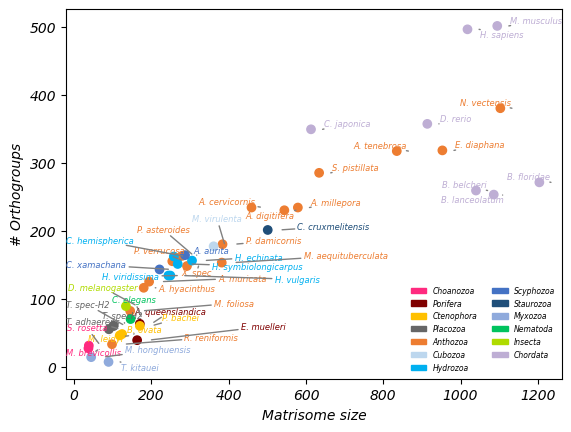

In [ ]:
scatter_plot_with_labels(size_OG,seq_row="clean_sequences",OG_row="clean_orthogroups")
plt.title = "all curated orthogroups"
plt.savefig(output_path / "no_other_Orthogroup_Matrisome_size.svg")
plt.show()

An interesting question to ask is how many proteins are in the differnten orthogroups for each species.

C:\Users\gideon.b\AppData\Local\Temp\ipykernel_11444\2594910142.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  HOG_count = HOGs.iloc[:, 2:].applymap(lambda x: [] if pd.isna(x) else x.split(",")).applymap(len)
100%|██████████| 48/48 [00:37<00:00,  1.29it/s]


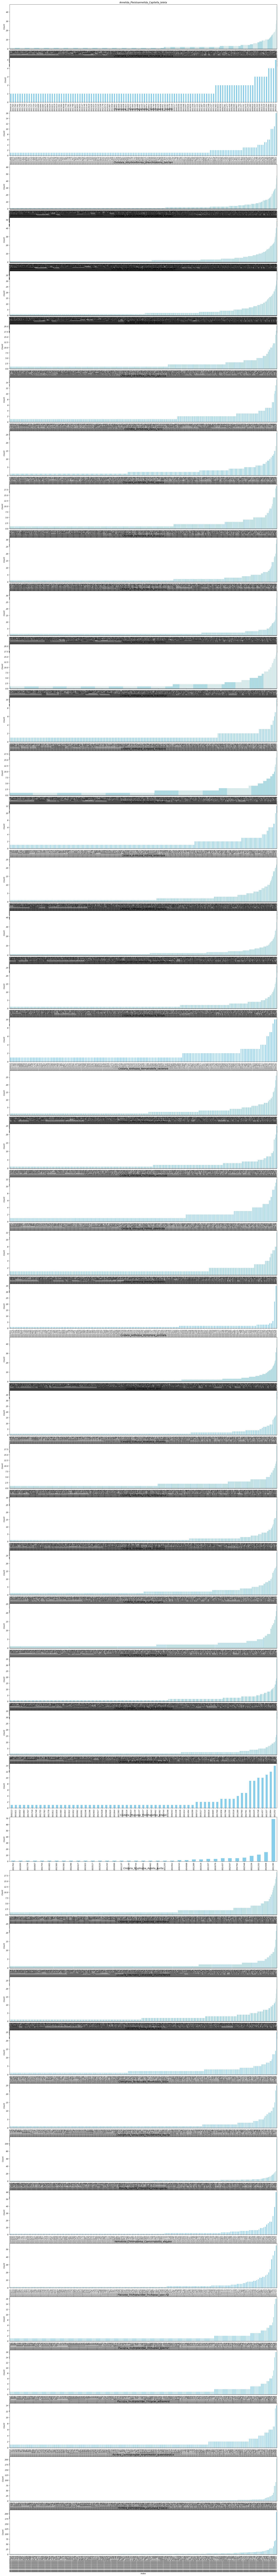

In [ ]:
#create a table that contains the number of proteins per HOG
HOG_count = HOGs.iloc[:, 2:].applymap(lambda x: [] if pd.isna(x) else x.split(",")).applymap(len)
HOG_count.to_csv(output_path / "HOG_count.csv")

# Create the figure and subplots
num_species = len(HOG_count.columns)
fig, axs = plt.subplots(nrows=num_species, ncols=1, figsize=(25, num_species*5))

# Plot each column's bar chart
for i, col in tqdm(enumerate(HOG_count.columns),total=len(HOG_count.columns)):
    
    # Filter out rows that are not 0
    col_values = HOG_count[col][HOG_count[col] != 0]
    col_values = col_values.sort_values()
    col_values.plot(kind='bar', ax=axs[i], color='skyblue')
    

    # Set subplot title and axis labels
    axs[i].set_title(col)
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Count')

# Adjust layout and spacing
#plt.tight_layout()
plt.savefig(graph_path / "Proteins_per_HOG.pdf")
plt.show()

## Export the orthogroups of specific species
first just the table

In [ ]:
species_of_interest = ['Chordata_Amphioxiformes_Branchiostoma_lanceolatum',
       'Chordata_Amphioxiformes_Branchiostoma_floridae']
#save the table
#HOGs[species_of_interest].dropna().to_csv(r"C:\Users\gideon.b\Desktop\Noriko\sponge_orthogroups.csv")

then also the sequences

In [ ]:
species_of_interest_list = ["_".join([ts_id.split("_")[-2],ts_id.split("_")[-1]]) for ts_id in species_of_interest]
sequence_folder = Path(r"output\Sequences")
reduced_HOGs = HOGs[species_of_interest].dropna()
reduced_HOGs.columns = species_of_interest_list

In [ ]:
def export_sequences(reduced_HOGs, sequence_folder, output_folder,output_formats=[("gb","genebank")]):
    """
    Process sequences from a pandas DataFrame of reduced HOGs and save them in the specified output folder.

    Args:
        reduced_HOGs (pandas.DataFrame): A DataFrame containing information about orthogroups and sequences.
            Index should be species names, and columns should be orthogroup names.
            Values should be comma-separated strings of sequence IDs.
        sequence_folder (str or Path): The path to the folder containing sequence files for each species.
        output_folder (str or Path): The path to the folder where the processed sequences will be saved.

    Returns:
        None
    """
    # Suppress BiopythonParserWarning
    warnings.filterwarnings("ignore", category=BiopythonParserWarning)

    # Create the destination folder (if it doesn't exist)
    destination_folder = Path(output_folder)
    destination_folder.mkdir(parents=True, exist_ok=True)

    # Iterate over each column (species) in the dataframe
    for species, orthogroups in reduced_HOGs.items():
        species = "_".join(species.rsplit('_', 2)[-2:])
        # Open the .gb source file
        source_path = sequence_folder / species / f"{species}_matrisome.gb"
        print(f"Read sequences for {source_path}")
        if source_path.exists():
            with open(source_path, "r") as source_file:
                source_records = SeqIO.to_dict(SeqIO.parse(source_file, "genbank"))

                # Iterate over each orthogroup in the column
                for orthogroup, value in orthogroups.items():
                    if value is not None and type(value) is not float:
                        seq_ids = value.split(',')
                        num_seqs= len(seq_ids)
                        seq_records = []
                        # Find sequences in the source file
                        for seq_id in seq_ids:
                            seq_id = seq_id.strip()
                            seq_id = seq_id.split(" ")[0]
                            if seq_id:
                                seq_records.append(source_records[seq_id])

                        if seq_records:
                            for record in seq_records:
                                record.annotations["molecule_type"] = "protein"
                           

                            # Write the sequences to the destination files
                            for format in output_formats:
                                # Create the destination file paths
                                destination_path = destination_folder / f"{species}_{orthogroup}.{format[0]}"
                            
                                gbs = SeqIO.write(seq_records, destination_path, format[1])



    warnings.resetwarnings()


In [ ]:
#export_sequences(reduced_HOGs, sequence_folder, output_folder)

## Export only the orthogroups that are specific for a species/taxon

In [ ]:
# optionally select new species or taxa
species_of_interest = species_of_interest
excluded_columns = ['OG', 'Gene Tree Parent Clade']

# Create a boolean mask for rows with at least one non-NaN value in the columns of interest
species_of_interest_mask = HOGs[species_of_interest].notna().any(axis=1)

# Create a DataFrame containing only the columns outside of the specified subset and excluded columns
other_columns_df = HOGs.drop(species_of_interest + excluded_columns, axis=1)

# Create a boolean mask for rows where all columns outside the subset and excluded columns are NaN
other_columns_mask = other_columns_df.isna().all(axis=1)

# Combine the two masks to get the final result
result = HOGs[species_of_interest_mask & other_columns_mask]

# Print the resulting DataFrame
exclusive_HOGs = result[species_of_interest]

In [ ]:
#export_sequences(exclusive_HOGs, sequence_folder, r"output\Sequences\_orthogroup_sequences")

So lets take a look at the phylogenetical distribution of the different orthogroups.

In [ ]:
HOGs.head()

OG Gene Tree Parent Clade  \
HOG                                               
N0.HOG0000000  OG0000000                     n3   
N0.HOG0000001  OG0000000                     n5   
N0.HOG0000002  OG0000000                     n7   
N0.HOG0000003  OG0000000                    n34   
N0.HOG0000004  OG0000000                    n58   

              Annelida_Pleistoannelida_Capitella_teleta  \
HOG                                                       
N0.HOG0000000                                       NaN   
N0.HOG0000001                                       NaN   
N0.HOG0000002                                       NaN   
N0.HOG0000003                                       NaN   
N0.HOG0000004                                       NaN   

              Choanozoa_Choanoflagellatea_Monosiga_brevicollis  \
HOG                                                              
N0.HOG0000000                                              NaN   
N0.HOG0000001                                              NaN   
N0.HOG0000002                                              NaN   
N0.HOG0000003                                              NaN   
N0.HOG0000004                                              NaN   

              Choanozoa_Choanoflagellatea_Salpingoeca_rosetta  \
HOG                                                             
N0.HOG0000000                                             NaN   
N0.HOG0000001                                             NaN   
N0.HOG0000002                                             NaN   
N0.HOG0000003                                             NaN   
N0.HOG0000004                                             NaN   

                  Chordata_Amphioxiformes_Branchiostoma_belcheri  \
HOG                                                                
N0.HOG0000000                                                NaN   
N0.HOG0000001                                                NaN   
N0.HOG0000002  Branchiostoma_belcheri_tr_A0A6P4ZY46_A0A6P4ZY4...   
N0.HOG0000003                                                NaN   
N0.HOG0000004                                                NaN   

                  Chordata_Amphioxiformes_Branchiostoma_floridae  \
HOG                                                                
N0.HOG0000000                                                NaN   
N0.HOG0000001                                                NaN   
N0.HOG0000002  Branchiostoma_floridae_tr_A0A9J7LWS5_A0A9J7LWS...   
N0.HOG0000003                                                NaN   
N0.HOG0000004                                                NaN   

              Chordata_Amphioxiformes_Branchiostoma_lanceolatum  \
HOG                                                               
N0.HOG0000000                                               NaN   
N0.HOG0000001                                               NaN   
N0.HOG0000002                                               NaN   
N0.HOG0000003                                               NaN   
N0.HOG0000004                                               NaN   

              Chordata_Vertebrata_Bos_taurus  \
HOG                                            
N0.HOG0000000                            NaN   
N0.HOG0000001                            NaN   
N0.HOG0000002                            NaN   
N0.HOG0000003                            NaN   
N0.HOG0000004                            NaN   

              Chordata_Vertebrata_Coturnix_japonica  ...  \
HOG                                                  ...   
N0.HOG0000000                                   NaN  ...   
N0.HOG0000001                                   NaN  ...   
N0.HOG0000002                                   NaN  ...   
N0.HOG0000003                                   NaN  ...   
N0.HOG0000004                                   NaN  ...   

                                     Ctenophora_Nuda_Beroe_ovata  \
HOG                                                                
N0.HOG0000000

e:\mesoglea_protein_pipeline\.venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


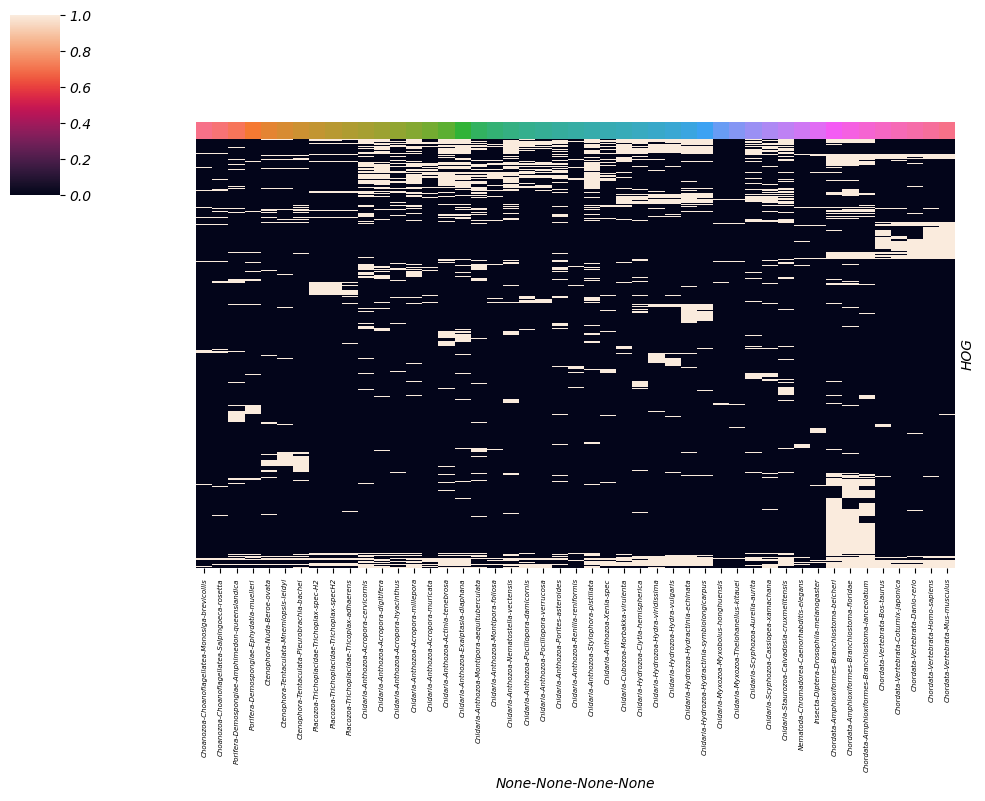

In [ ]:
bool_HOGs =  HOGs.iloc[:,2:].notna()
bool_HOGs = bool_HOGs.reindex(sorted(bool_HOGs.columns), axis=1)

# Split column names and create multi-level index
columns = bool_HOGs.columns.str.split("_", expand=True)
multi_index = pd.MultiIndex.from_tuples(columns)

# Assign the multi-level index to the DataFrame
bool_HOGs.columns = multi_index
bool_HOGs = bool_HOGs[custom_order]
# Extract the first element from each column name using split("_")
first_elements = bool_HOGs.index.get_level_values(0)


# Get unique first elements and assign colors to them
unique_elements = sorted(set(first_elements))
n_elements = len(unique_elements)
color_palette = sns.color_palette("husl", n_elements)

# Create a color map to map first elements to colors
element_to_color = {element: color for element, color in zip(unique_elements, color_palette)}

# Convert first elements to colors for each column
column_colors = [element_to_color[element] for element in first_elements]

cluster_map = sns.clustermap(bool_HOGs,xticklabels=True,yticklabels=False,col_colors=column_colors,col_cluster=False)
cluster_map.ax_row_dendrogram.set_visible(False)
cluster_map.ax_heatmap.set_xticklabels(cluster_map.ax_heatmap.get_xmajorticklabels(), fontsize = 5)
#cluster_map.ax_heatmap.set_yticklabels(cluster_map.ax_heatmap.get_ymajorticklabels(), fontsize = 2)
plt.savefig("output/graphs/HOGs_bool.svg")

In [ ]:
# Function to determine the levels of taxons in the DataFrame columns
def get_taxon_sub_HOGS(taxon_names, df=bool_HOGs):
    # Initialize a dictionary to store the search levels for each taxon
    search_levels = {column_name: False for column_name in taxon_names}

    # Iterate over the levels of DataFrame columns
    for level, level_categories in enumerate(df.columns.levels):
        # Check if each taxon is present in the current level
        for column_name in taxon_names:
            if column_name in level_categories:
                # If found, store the level for the taxon
                search_levels[column_name] = level
            if all(search_levels.values()):
                # If all taxons are found, break from the loop
                break

    # Return the dictionary containing search levels for each taxon
    return search_levels

# Function to get subsets of HOGs for each taxon based on search levels
def get_taxon_HOG_sets(taxon_names, df=bool_HOGs):
    # Get search levels for each taxon using the previous function
    search_levels = get_taxon_sub_HOGS(taxon_names=taxon_names, df=df)
    df_subsets = {}

    # Iterate over taxons
    for column_name in taxon_names:
        # Extract columns for the specific taxon at the determined level
        sel_columns = df.xs(column_name, axis=1, level=search_levels[column_name], drop_level=False)
        # Store the subset of HOGs for the taxon
        df_subsets[column_name] = set(sel_columns[sel_columns.any(axis=1)].index)

    # Return a dictionary containing subsets of HOGs for each taxon
    return df_subsets

# Function to create a Venn diagram for taxons and save the plot
def create_taxon_venn(taxon_names, df=bool_HOGs, true_venn=False):
    # Get subsets of HOGs for each taxon
    df_subsets = get_taxon_HOG_sets(taxon_names, df=bool_HOGs)
    num_sets = len(taxon_names)

    # Check if a true Venn diagram with specific sets is requested
    if true_venn:
        if num_sets == 2:
            # Create a 2-set Venn diagram
            venn_graph = venn2([df_subsets[taxon_names[0]], df_subsets[taxon_names[1]]],
                               set_labels=taxon_names, set_colors=color_map)
        elif num_sets == 3:
            # Create a 3-set Venn diagram
            venn_graph = venn3([df_subsets[taxon_names[0]], df_subsets[taxon_names[1]], df_subsets[taxon_names[2]]],
                               set_labels=taxon_names, set_colors=color_map)
        else:
            # Raise an error for unsupported number of sets
            raise ValueError("Only 2 or 3 sets are supported for Venn diagrams.")
    else:
        # Create a standard Venn diagram with all possible intersections
        venn_graph = venn(df_subsets, cmap=color_map)

    # Save the Venn diagram plot as an SVG file
    plt.savefig("output\\graphs\\venn_diagrams.svg")
    # Display the plot
    plt.show()

In [ ]:
# Assume bool_HOGs is a DataFrame containing HOG information

# Function to determine the hierarchical levels of taxon names in the DataFrame columns
def get_taxon_sub_HOGS(taxon_names, df=bool_HOGs):
    # Dictionary to store the levels of each taxon name
    search_levels = {column_name: False for column_name in taxon_names}
    
    # Iterate over the levels of DataFrame columns
    for level, level_categories in enumerate(df.columns.levels):
        for column_name in taxon_names:
            # Check if the taxon name is in the current level's categories
            if column_name in level_categories:
                search_levels[column_name] = level
            # If all taxon names are found, break out of the loop
            if all(search_levels.values()):
                break
    return search_levels

# Function to get subsets of HOGs for each taxon name
def get_taxon_HOG_sets(taxon_names, df=bool_HOGs, exclude_unspecified=True):
    # Get the hierarchical levels for taxon names
    search_levels = get_taxon_sub_HOGS(taxon_names=taxon_names, df=df)
    df_subsets = {}

    # Optional filtering step to exclude rows with values in unspecified taxons
    if exclude_unspecified:
        # Create a mask to identify rows with values in unspecified taxons
        mask_unspecified = ~df.index.isin(df.index[df.iloc[:, :search_levels[taxon_names[0]]].notna().any(axis=1)])

        # Apply the mask to the DataFrame
        df = df[mask_unspecified]

    # Iterate over taxon names
    for column_name in taxon_names:
        # Extract columns at the specified level for each taxon name
        sel_columns = df.xs(column_name, axis=1, level=search_levels[column_name], drop_level=False)
        # Store the set of indices where the taxon is present
        df_subsets[column_name] = set(sel_columns[sel_columns.any(axis=1)].index)
    return df_subsets

# Function to create and display a Venn diagram for taxon subsets
def create_taxon_venn(taxon_names, df=bool_HOGs, true_venn=False, exclude_unspecified=True):
    # Get subsets of HOGs for each taxon name
    df_subsets = get_taxon_HOG_sets(taxon_names, df=df, exclude_unspecified=exclude_unspecified)
    num_sets = len(taxon_names)

    # Create Venn diagram using matplotlib_venn library
    if true_venn:
        if num_sets == 2:
            venn_graph = venn2([df_subsets[taxon_names[0]], df_subsets[taxon_names[1]]], set_labels=taxon_names, set_colors=color_map)
        elif num_sets == 3:
            venn_graph = venn3([df_subsets[taxon_names[0]], df_subsets[taxon_names[1]], df_subsets[taxon_names[2]]], set_labels=taxon_names, set_colors=color_map)
        else:
            raise ValueError("Only 2 or 3 sets are supported for Venn diagrams.")
    else:
        # Use default Venn diagram if true_venn is False
        venn_graph = venn(df_subsets, cmap=color_map)
    
    # Display and save the Venn diagram
    print(venn_graph)
    plt.savefig("output\\graphs\\venn_diagrams.svg")
    plt.show()

Axes(0.125,0.11;0.775x0.77)


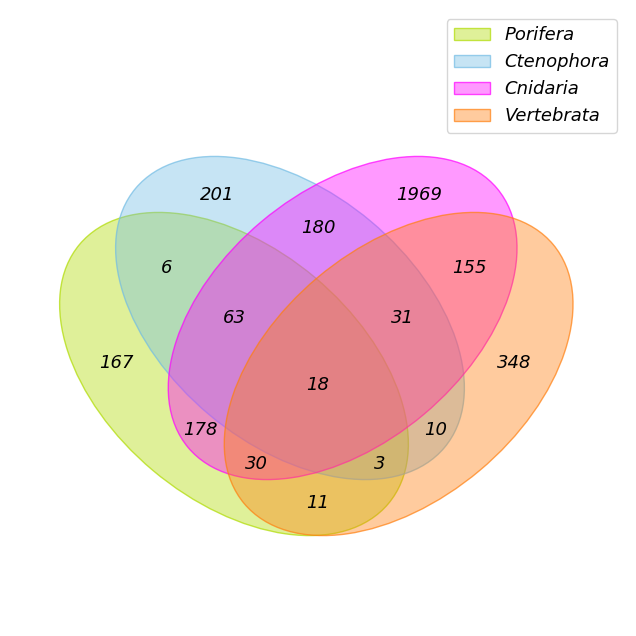

In [ ]:
taxon_names = ["Porifera","Ctenophora",'Cnidaria', 'Vertebrata']
create_taxon_venn(taxon_names,exclude_unspecified=True)


In [ ]:
df_subsets = get_taxon_HOG_sets(taxon_names, df=bool_HOGs, exclude_unspecified=True)
Porifera_OGs = df_subsets["Porifera"]
Ctenophora_OGs = df_subsets["Ctenophora"]
Cnidaria_OGs = df_subsets["Cnidaria"]
Vertebrata_OGs = df_subsets["Vertebrata"]


In [ ]:
# Intersections
intersection_Porifera_Ctenophora = Porifera_OGs.intersection(Ctenophora_OGs) - Cnidaria_OGs - Vertebrata_OGs
intersection_Porifera_Cnidaria = Porifera_OGs.intersection(Cnidaria_OGs) - Ctenophora_OGs - Vertebrata_OGs
intersection_Porifera_Vertebrata = Porifera_OGs.intersection(Vertebrata_OGs) - Ctenophora_OGs - Cnidaria_OGs
intersection_Ctenophora_Cnidaria = Ctenophora_OGs.intersection(Cnidaria_OGs) - Porifera_OGs - Vertebrata_OGs
intersection_Ctenophora_Vertebrata = Ctenophora_OGs.intersection(Vertebrata_OGs) - Porifera_OGs - Cnidaria_OGs
intersection_Cnidaria_Vertebrata = Cnidaria_OGs.intersection(Vertebrata_OGs) - Porifera_OGs - Ctenophora_OGs
intersection_Porifera_Ctenophora_Cnidaria = Porifera_OGs.intersection(Ctenophora_OGs, Cnidaria_OGs) - Vertebrata_OGs
intersection_Porifera_Ctenophora_Vertebrata = Porifera_OGs.intersection(Ctenophora_OGs, Vertebrata_OGs) - Cnidaria_OGs
intersection_Porifera_Cnidaria_Vertebrata = Porifera_OGs.intersection(Cnidaria_OGs, Vertebrata_OGs) - Ctenophora_OGs
intersection_Ctenophora_Cnidaria_Vertebrata = Ctenophora_OGs.intersection(Cnidaria_OGs, Vertebrata_OGs) - Porifera_OGs
intersection_Porifera_Ctenophora_Cnidaria_Vertebrata = Porifera_OGs.intersection(Ctenophora_OGs, Cnidaria_OGs, Vertebrata_OGs)



# Print the length of each intersection
print("Length of Porifera ∩ Ctenophora:", len(intersection_Porifera_Ctenophora))
print("Length of Porifera ∩ Cnidaria:", len(intersection_Porifera_Cnidaria))
print("Length of Porifera ∩ Vertebrata:", len(intersection_Porifera_Vertebrata))
print("Length of Ctenophora ∩ Cnidaria:", len(intersection_Ctenophora_Cnidaria))
print("Length of Ctenophora ∩ Vertebrata:", len(intersection_Ctenophora_Vertebrata))
print("Length of Cnidaria ∩ Vertebrata:", len(intersection_Cnidaria_Vertebrata))
print("Length of Porifera ∩ Ctenophora ∩ Cnidaria:", len(intersection_Porifera_Ctenophora_Cnidaria))
print("Length of Porifera ∩ Ctenophora ∩ Vertebrata:", len(intersection_Porifera_Ctenophora_Vertebrata))
print("Length of Porifera ∩ Cnidaria ∩ Vertebrata:", len(intersection_Porifera_Cnidaria_Vertebrata))
print("Length of Ctenophora ∩ Cnidaria ∩ Vertebrata:", len(intersection_Ctenophora_Cnidaria_Vertebrata))
print("Length of Porifera ∩ Ctenophora ∩ Cnidaria ∩ Vertebrata:", len(intersection_Porifera_Ctenophora_Cnidaria_Vertebrata))

Length of Porifera ∩ Ctenophora: 6
Length of Porifera ∩ Cnidaria: 178
Length of Porifera ∩ Vertebrata: 11
Length of Ctenophora ∩ Cnidaria: 180
Length of Ctenophora ∩ Vertebrata: 10
Length of Cnidaria ∩ Vertebrata: 155
Length of Porifera ∩ Ctenophora ∩ Cnidaria: 63
Length of Porifera ∩ Ctenophora ∩ Vertebrata: 3
Length of Porifera ∩ Cnidaria ∩ Vertebrata: 30
Length of Ctenophora ∩ Cnidaria ∩ Vertebrata: 31
Length of Porifera ∩ Ctenophora ∩ Cnidaria ∩ Vertebrata: 18


In [ ]:
def extract_HOG_seqs(list_of_HOG_ids,name):
    for HOG in tqdm(list_of_HOG_ids):
        HOG_fastas = []
        hog_list = pd.read_csv(r"output\orthofinder_input\matrisome\OrthoFinder\Results_Oct23\Phylogenetic_Hierarchical_Orthogroups\N0.tsv",
                            index_col=0,
                            sep = "\t")
        subset = hog_list.loc[HOG].drop(["OG","Gene Tree Parent Clade","Annelida_Pleistoannelida_Capitella_teleta"]).dropna()

        for species in subset.index: #iterate over rows
            species_seq_ids = subset.values
            species_seqs = SeqIO.parse(f"output\orthofinder_input\matrisome\{species}.fasta","fasta")
            for seq_record in species_seqs:
                if any(seq_record.id in species_seq_id for species_seq_id in species_seq_ids):
                    HOG_fastas.append(seq_record)
        outdir= Path(r"output\orthofinder_input\matrisome\Orthogroup_analysis\sequence")/ f"{name}" 
        outdir.mkdir(parents=True,exist_ok=True)
        outpath = outdir / f"{HOG}.fasta"
        SeqIO.write(HOG_fastas, outpath ,"fasta")


In [ ]:
# Example function calls for each intersection
# Example function calls for each intersection
extract_HOG_seqs(list_of_HOG_ids=intersection_Porifera_Ctenophora,
                 name="Porifera_Ctenophora")

extract_HOG_seqs(list_of_HOG_ids=intersection_Porifera_Cnidaria,
                 name="Porifera_Cnidaria")

extract_HOG_seqs(list_of_HOG_ids=intersection_Porifera_Vertebrata,
                 name="Porifera_Vertebrata")

extract_HOG_seqs(list_of_HOG_ids=intersection_Ctenophora_Cnidaria,
                 name="Ctenophora_Cnidaria")

extract_HOG_seqs(list_of_HOG_ids=intersection_Ctenophora_Vertebrata,
                 name="Ctenophora_Vertebrata")

extract_HOG_seqs(list_of_HOG_ids=intersection_Cnidaria_Vertebrata,
                 name="Cnidaria_Vertebrata")

extract_HOG_seqs(list_of_HOG_ids=intersection_Porifera_Ctenophora_Cnidaria,
                 name="Porifera_Ctenophora_Cnidaria")

extract_HOG_seqs(list_of_HOG_ids=intersection_Porifera_Ctenophora_Vertebrata,
                 name="Porifera_Ctenophora_Vertebrata")

extract_HOG_seqs(list_of_HOG_ids=intersection_Porifera_Cnidaria_Vertebrata,
                 name="Porifera_Cnidaria_Vertebrata")

extract_HOG_seqs(list_of_HOG_ids=intersection_Ctenophora_Cnidaria_Vertebrata,
                 name="Ctenophora_Cnidaria_Vertebrata")

extract_HOG_seqs(list_of_HOG_ids=intersection_Porifera_Ctenophora_Cnidaria_Vertebrata,
                 name="Porifera_Ctenophora_Cnidaria_Vertebrata")


100%|██████████| 18/18 [00:14<00:00,  1.23it/s]


In [ ]:
def save_intersections_as_single_csv(intersection_sets):
    # Find the maximum length of any intersection set
    max_length = max(len(intersection_set) for intersection_set, _ in intersection_sets)

    # Create a DataFrame with each intersection set as a column
    data_dict = {name: list(intersection_set) + [None] * (max_length - len(intersection_set)) for intersection_set, name in intersection_sets}
    df_intersection = pd.DataFrame(data_dict)

    # Save the DataFrame as a CSV file
    outdir = Path(r"output\orthofinder_input\matrisome\Orthogroup_analysis\sequence")
    outdir.mkdir(parents=True, exist_ok=True)
    outpath_csv = outdir / "all_intersections_elements.csv"
    df_intersection.to_csv(outpath_csv, index=False)

In [ ]:
# List of intersection sets and their corresponding names
intersection_sets = [
    (intersection_Porifera_Ctenophora, "Porifera_Ctenophora"),
    (intersection_Porifera_Cnidaria, "Porifera_Cnidaria"),
    (intersection_Porifera_Vertebrata, "Porifera_Vertebrata"),
    (intersection_Ctenophora_Cnidaria, "Ctenophora_Cnidaria"),
    (intersection_Ctenophora_Vertebrata, "Ctenophora_Vertebrata"),
    (intersection_Cnidaria_Vertebrata, "Cnidaria_Vertebrata"),
    (intersection_Porifera_Ctenophora_Cnidaria, "Porifera_Ctenophora_Cnidaria"),
    (intersection_Porifera_Ctenophora_Vertebrata, "Porifera_Ctenophora_Vertebrata"),
    (intersection_Porifera_Cnidaria_Vertebrata, "Porifera_Cnidaria_Vertebrata"),
    (intersection_Ctenophora_Cnidaria_Vertebrata, "Ctenophora_Cnidaria_Vertebrata"),
    (intersection_Porifera_Ctenophora_Cnidaria_Vertebrata, "Porifera_Ctenophora_Cnidaria_Vertebrata")
]

# Save all intersection sets in a single CSV file
save_intersections_as_single_csv(intersection_sets)

What does this look like we we look at the actual numbe rof proteins in every HOG?

C:\Users\gideon.b\AppData\Local\Temp\ipykernel_11444\418928747.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  HOGs_per_spec_count =  HOGs.iloc[:,2:].applymap(lambda x:calculate_list_length(x) if isinstance(x, str) else 0)


e:\mesoglea_protein_pipeline\.venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


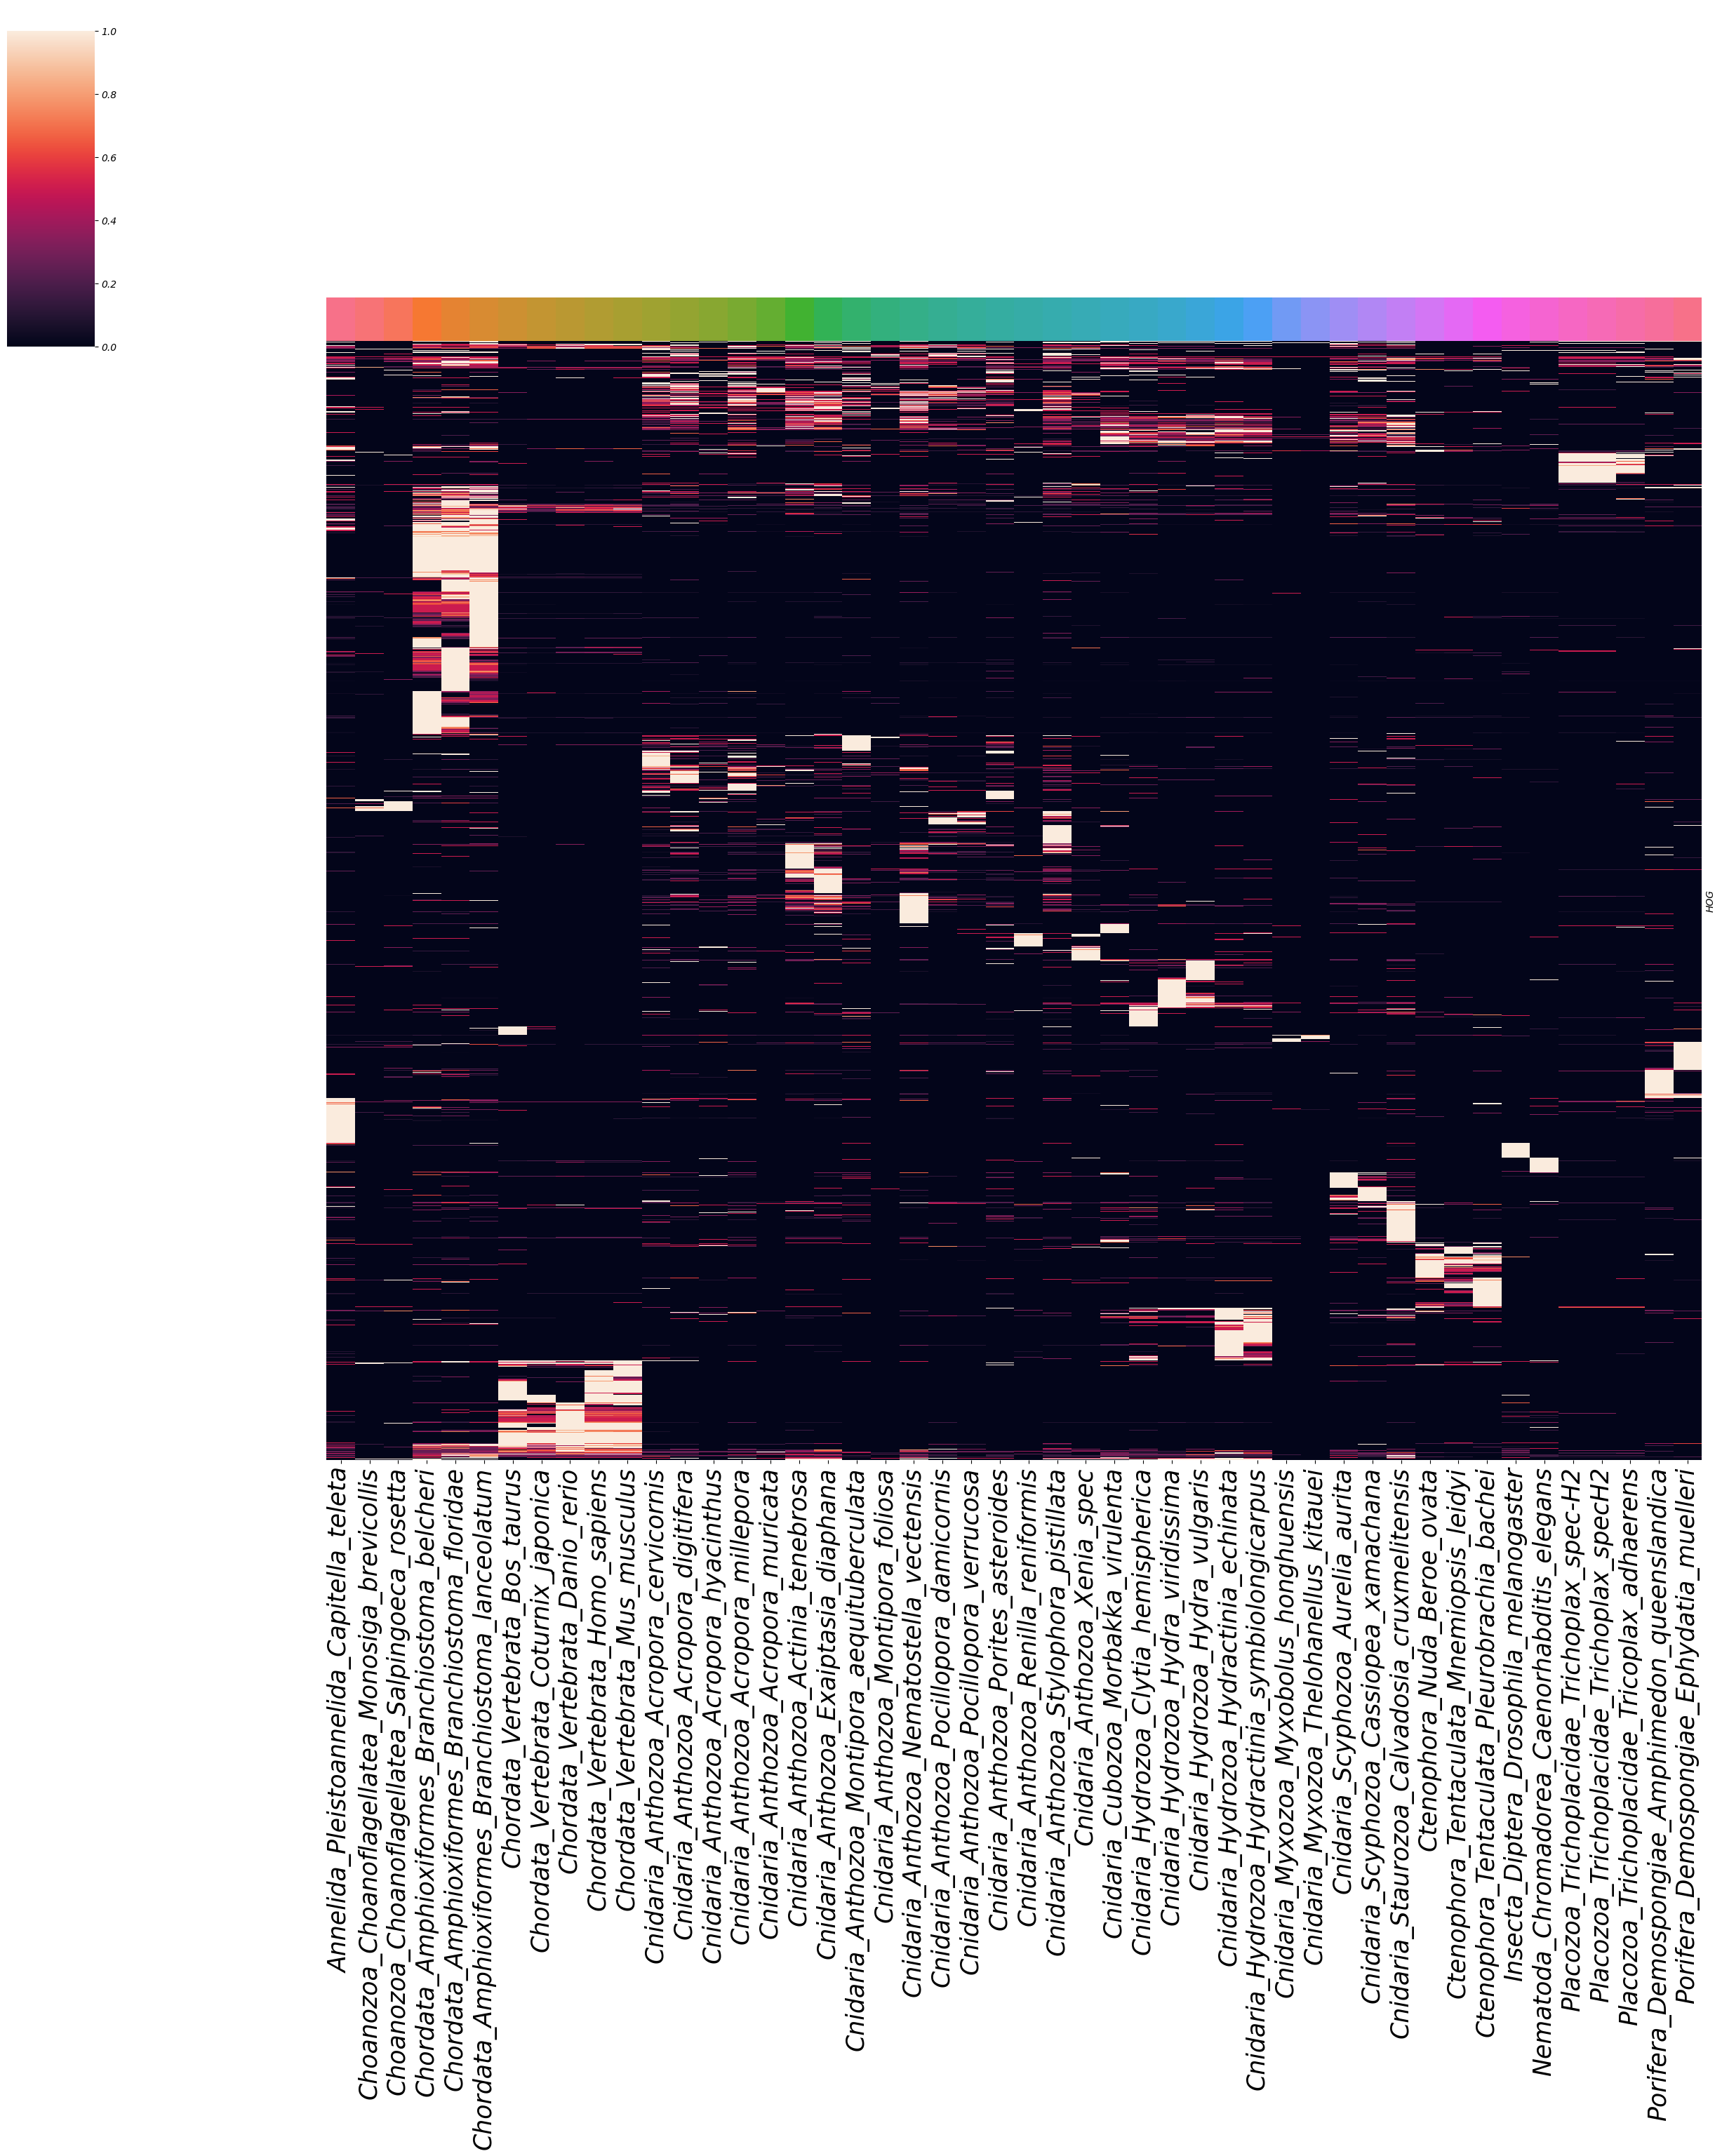

In [ ]:
def calculate_list_length(string_list):
    return len(string_list.split(', '))

HOGs_per_spec_count =  HOGs.iloc[:,2:].applymap(lambda x:calculate_list_length(x) if isinstance(x, str) else 0)
HOGs_per_spec_count = HOGs_per_spec_count.reindex(sorted(HOGs_per_spec_count.columns),axis=1)
# Get unique first elements and assign colors to them
unique_elements = sorted(set(first_elements))
n_elements = len(unique_elements)
color_palette = sns.color_palette("husl", n_elements)

# Create a color map to map first elements to colors
element_to_color = {element: color for element, color in zip(unique_elements, color_palette)}

# Convert first elements to colors for each column
column_colors = [element_to_color[element] for element in first_elements]

cluster_map = sns.clustermap(HOGs_per_spec_count,
        xticklabels=True,
        yticklabels=False,
        col_colors=column_colors,
        standard_scale=0,
        col_cluster=False,
        figsize=(25,25))
cluster_map.ax_row_dendrogram.set_visible(False)
cluster_map.ax_heatmap.set_xticklabels(cluster_map.ax_heatmap.get_xmajorticklabels(), fontsize = 25,)
plt.savefig("output/graphs/HOGs_count.svg")
plt.savefig("output/graphs/HOGs_count.png")

What orthogroups are exclusive for the different taxa? We need ot create some function to analyse this

In [ ]:
def exclusivity_check(term,df = bool_HOGs):
  # find the columns that contain the string 'specific'
  cols_to_check = [col for col in df.columns if term in col]

  # create a boolean mask that checks if any of the values in the columns containing the specified string are True
  mask = df[cols_to_check].any(axis=1)

  # exclude any rows that have True values in columns not specified for checking
  mask &= ~df.loc[:, df.columns.difference(cols_to_check)].any(axis=1)

  # select the rows that match the mask
  result = df.loc[mask]

  # print the resulting dataframe
  return result

# we need to split the names into pairs of taxon and subtaxon 
def get_existing_pairs(cols):
    existing_pairs = set()
    for col in cols:
        levels = col
        for i in range(len(levels)-1):
            if levels[i+1] != "teleta":
                existing_pairs.add((levels[i], levels[i+1]))
    return existing_pairs

In [ ]:
exclusivity_check("Porifera",df = bool_HOGs).shape[0]

130

0


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
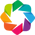

e:\mesoglea_protein_pipeline\.venv\Lib\site-packages\holoviews\core\util.py:1175: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.unique(values)
e:\mesoglea_protein_pipeline\.venv\Lib\site-packages\holoviews\core\util.py:1175: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.unique(values)
e:\mesoglea_protein_pipeline\.venv\Lib\site-packages\holoviews\core\util.py:1175: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.unique(values)
e:\mesoglea_protein_pipeline\.venv\Lib\site-packages\holoviews\core\util.py:1175: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future vers

:Sankey   [source,target]   (value)

In [ ]:
HOG_size =  bool_HOGs.shape[0]
tax_pairs = get_existing_pairs(bool_HOGs.columns)
# the phyla need to be paired with the overall matrisome
phyla = set(first_elements)

#find the exclusive HOGs for each Taxon
sankey_list = list()
for pair1,pair2 in tax_pairs:
    res = exclusivity_check("{}".format(pair2)).shape[0]
    if res > 0 :
        sankey_list.append([pair1,pair2,res])
top_level_size = 0
for phylum in phyla:
    res = exclusivity_check(phylum).shape[0]
    if res > 0 :
        top_level_size += res
        sankey_list.append(["All in silico matrisome HOGs",phylum,res])
print(top_level_size)
#sankey_list.append(["All in silico matrisome HOGs","shared",HOG_size - top_level_size])    

#create a pandas df
sankey_df = pd.DataFrame(sankey_list)
sankey_df.columns = ["source","target","value"]

hv.extension('bokeh')

sankey = hv.Sankey(sankey_df, label='Exlusive hirarchical orthogroups')
sankey.output_backend = "svg"
sankey.opts(label_position='outer', edge_color='target', node_color='index', cmap='tab20',node_padding=10,node_sort = True)

In [ ]:
def export_svg(obj, filename):
    plot_state = hv.renderer('bokeh').get_plot(obj).state
    plot_state.output_backend = 'svg'
    export_svgs(plot_state, filename=filename)

export_svg(sankey, graph_path / 'exclusive_HOGs_sankey.svg')

e:\mesoglea_protein_pipeline\.venv\Lib\site-packages\holoviews\core\util.py:1175: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.unique(values)
e:\mesoglea_protein_pipeline\.venv\Lib\site-packages\holoviews\core\util.py:1175: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.unique(values)
e:\mesoglea_protein_pipeline\.venv\Lib\site-packages\holoviews\core\util.py:1175: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.unique(values)
e:\mesoglea_protein_pipeline\.venv\Lib\site-packages\holoviews\core\util.py:1175: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future vers

What HOGs are exclusive to Cnidarians?

In [ ]:
cnidaria_columns = [col for col in bool_HOGs.columns if 'Cnidaria' in col]
condition = (bool_HOGs[cnidaria_columns].any(axis=1)) & (~bool_HOGs.drop(cnidaria_columns, axis=1).any(axis=1))
result = bool_HOGs[condition]
result

Choanozoa                  Porifera            \
              Choanoflagellatea              Demospongiae             
                       Monosiga Salpingoeca    Amphimedon Ephydatia   
                    brevicollis     rosetta queenslandica  muelleri   
HOG                                                                   
N0.HOG0000000             False       False         False     False   
N0.HOG0000001             False       False         False     False   
N0.HOG0000004             False       False         False     False   
N0.HOG0000009             False       False         False     False   
N0.HOG0000015             False       False         False     False   
...                         ...         ...           ...       ...   
N0.HOG0004105             False       False         False     False   
N0.HOG0004106             False       False         False     False   
N0.HOG0004107             False       False         False     False   
N0.HOG0004108             False       False         False     False   
N0.HOG0004109             False       False         False     False   

              Ctenophora                                 Placozoa         \
                    Nuda Tentaculata               Trichoplacidae          
                   Beroe  Mnemiopsis Pleurobrachia     Trichoplax          
                   ovata      leidyi        bachei        spec-H2 specH2   
HOG                                                                        
N0.HOG0000000      False       False         False          False  False   
N0.HOG0000001      False       False         False          False  False   
N0.HOG0000004      False       False         False          False  False   
N0.HOG0000009      False       False         False          False  False   
N0.HOG0000015      False       False         False          False  False   
...                  ...         ...           ...            ...    ...   
N0.HOG0004105      False       False         False          False  False   
N0.HOG0004106      False       False         False          False  False   
N0.HOG0004107      False       False         False          False  False   
N0.HOG0004108      False       False         False          False  False   
N0.HOG0004109      False       False         False          False  False   

                         ...       Nematoda      Insecta       Chordata  \
                         ...    Chromadorea      Diptera Amphioxiformes   
              Tricoplax  ... Caenorhabditis   Drosophila  Branchiostoma   
              adhaerens  ...        elegans melanogaster       belcheri   
HOG                      ...                                              
N0.HOG0000000     False  ...          False        False          False   
N0.HOG0000001     False  ...          False        False          False   
N0.HOG0000004     False  ...          False        False          False   
N0.HOG0000009     False  ...          False        False          False   
N0.HOG0000015     False  ...          False        False          False   
...                 ...  ...            ...          ...            ...   
N0.HOG0004105     False  ...          False        False          False   
N0.HOG0004106     False  ...          False        False          False   
N0.HOG0004107     False  ...          False        False          False   
N0.HOG0004108     False  ...          False        False          False   
N0.HOG0004109     False  ...          False        False          False   

                                                                                
                                   Vertebrata                                   
                                          Bos Coturnix  Danio    Homo      Mus  
              floridae lanceolatum     taurus japonica  rerio sapiens musculus  
HOG                                                                             
N0.HOG0000000    False       False      False    False  False 